In [5]:
import torch as th
import numpy as np

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

# set random seed
np.random.seed(333)
th.manual_seed(333)
th.cuda.manual_seed(333)
th.backends.cudnn.deterministic = True


def kde_on_grid(z: th.Tensor, G: int, h: float) -> (th.Tensor, th.Tensor):
    z_min, z_max = z.min(), z.max()
    z_grid = th.linspace(z_min, z_max, steps=G, device=z.device)
    dz = z.view(-1, 1) - z_grid.view(1, -1)  # shape (N_points, G)
    kernels = th.exp(-0.5 * (dz / h) ** 2)
    density_grid = kernels.mean(dim=0)
    density_grid /= density_grid.sum() * (z_grid[1] - z_grid[0])  # normalize area to 1
    return z_grid, density_grid



BW = 23 * 1e6 # Bandwidth in bits per second
FPS = 10
PSZ = 4 * 16 # 4 channels of 16 bits each

NUM_POINTS = 480 * 480 # Number of points in the point cloud

D_Guaranteed = 0.7 # meters
D_exponent = 7 # exponent for the validity function


MFS = BW/FPS # Maximum Frame Size in bits

MAX_POINTS = int(np.min([MFS/PSZ, NUM_POINTS])) # Maximum number of points in the point cloud


# a tensor 480x480x4  pxl, pxl,(x,y,z,validity)
points = th.rand(480, 480, 4)*20



# read points from ../dataset/pointclouds/local.ply

points = th.from_numpy(np.loadtxt("work/pcls/local1.ply", skiprows=11, delimiter=" ", usecols=(0,1,2,3), max_rows=NUM_POINTS)).float()

## change the sign of z values

points[:,2] = -points[:,2]



tic = th.cuda.Event(enable_timing=True)
toc = th.cuda.Event(enable_timing=True)


points = points.view(-1, 4).contiguous()

print("points shape: ", points.shape)

############################# CLASSIC DIANE

tic.record()

diane_validity = 1/(points[:,2]/th.max(points[:,2]) + 1e-6)**D_exponent

print("max validity: ", th.max(diane_validity))

diane_validity[points[:,2] < D_Guaranteed] = th.max(diane_validity)

valid_classic_diane_indexes = th.multinomial(diane_validity, MAX_POINTS, replacement=False)
valid_classic_diane_points = points[valid_classic_diane_indexes]

toc.record()
th.cuda.synchronize()

time_classic_diane = tic.elapsed_time(toc)
print("elapsed time classic diane: ", time_classic_diane, "ms")

############################### KDE DIANE

tic.record()
# Parametri KDE
G = 50
h = 0.01 # larghezza kernel, da calibrare in base alle tue distanze

z = points[:, 2]

# Calcolo KDE sulla distanza
z_grid, density_grid = kde_on_grid(z, G, h)

# Interpolazione della densità per ogni punto con fallback numpy
density_at_points = th.from_numpy(
    np.interp(z.cpu().numpy(), z_grid.cpu().numpy(), density_grid.cpu().numpy())
).to(z.device)

# Validità originale (inversa normalizzata)
validity_original = 1 / (z / z.max() + 1e-6)**D_exponent

# distance guarantee

# validity_original[z < D_Guaranteed] = th.max(validity_original)

# Correzione della validità dividendo per densità locale (evita concentrazione su zone dense)
validity_corrected = validity_original / (density_at_points + 1e-8)


# Mantieni priorità per punti molto vicini (se vuoi)
validity_corrected[z < D_Guaranteed] = th.max(validity_corrected)

toc.record()
th.cuda.synchronize()

time_kde_diane = tic.elapsed_time(toc)
print("elapsed time kde diane: ", time_kde_diane, "ms")

# sample the point cloud using multinomial based on the validity

valid_new_diane_indexes = th.multinomial(validity_corrected, MAX_POINTS, replacement=False)

valid_new_diane_points = points[valid_new_diane_indexes]

#####################################

tic.record()

n_points = points.size(0)



valid_uniform_indexes = th.multinomial(th.ones(n_points), MAX_POINTS, replacement=False)
valid_uniform_points = points[valid_uniform_indexes]

toc.record()
th.cuda.synchronize()

time_uniform = tic.elapsed_time(toc)
print("elapsed time uniform: ", time_uniform, "ms")


frame_size = PSZ * valid_classic_diane_points.size(0)






points shape:  torch.Size([230400, 4])
max validity:  tensor(6131.6924)
elapsed time classic diane:  5.3442559242248535 ms
elapsed time kde diane:  64.48844909667969 ms
elapsed time uniform:  5.158080101013184 ms


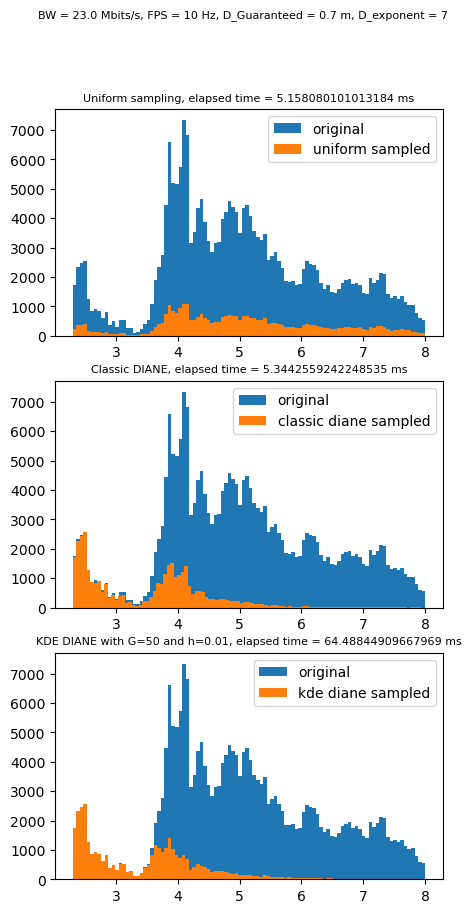

grabbed point cloud has 230400 points
to transmit it would be required a bandwidth of 147.456 Mbits/s
with a BW of 23.0 Mbits/s and FPS of 10 the maximum number of points that can be transmitted is 35937.5
points selected for transmission 35937
points selected for transmission (uniform) 35937


In [6]:
sample = valid_classic_diane_points[th.randint(0, valid_classic_diane_points.size(0), (1,))]

#print(valid_classic_diane_points)




# print cdf on z for original and sampled point cloud

# plot with size of plot 5x2
# subplots 3x1
BINS_FOR_PLOT = 100

plt.figure(figsize=(5, 10))

plt.suptitle("BW = "+str(BW/1e6)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, D_exponent = "+str(D_exponent), fontsize=8)
3.75 
plt.subplot(3, 1, 1)
plt.title("Uniform sampling, elapsed time = "+str(time_uniform)+" ms", fontsize=8)
plt.hist(points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='original')
plt.hist(valid_uniform_points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='uniform sampled')
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.title("Classic DIANE, elapsed time = "+str(time_classic_diane)+" ms", fontsize=8)
plt.hist(points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='original')
plt.hist(valid_classic_diane_points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='classic diane sampled')
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.title("KDE DIANE with G="+str(G)+" and h="+str(h)+", elapsed time = "+str(time_kde_diane)+" ms", fontsize=8)
plt.hist(points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='original')
plt.hist(valid_new_diane_points[:,2].numpy(), bins=BINS_FOR_PLOT, alpha=1, label='kde diane sampled')
plt.legend(loc='upper right')


# # finer ticks
# plt.xticks(np.arange(0, 20, 1))


plt.show()






print("grabbed point cloud has", n_points, "points")
print("to transmit it would be required a bandwidth of", n_points*PSZ*FPS/1000000, "Mbits/s")

print("with a BW of", BW/1e6, "Mbits/s and FPS of", FPS, "the maximum number of points that can be transmitted is", MFS/PSZ)

print("points selected for transmission", valid_classic_diane_points.size(0))
print("points selected for transmission (uniform)", valid_uniform_points.size(0))


